In [4]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
import time
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig

from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch 
import sklearn 


In [5]:
################## IMPORT MY MODULES ##################

import sys
sys.path.append('../src')
import joa_helpers as hlp
import cond_waveunet_dataset 
import cond_waveunet_model 
from cond_waveunet_traintest import infer
import cond_waveunet_eval as eval
import importlib
importlib.reload(hlp)
importlib.reload(cond_waveunet_dataset)
importlib.reload(cond_waveunet_dataset)
importlib.reload(eval)

<module 'cond_waveunet_eval' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/cond_waveunet_eval.py'>

In [48]:
################## SEARCH FOR DATA POINTS FROM TEST SET WITH SPECIFIC PROPERTIES   ##################

df_dataset=pd.read_csv('nonoise2_data_set.csv')
df_dataset=df_dataset[df_dataset["split"]=="test"]
custom_index = np.repeat(np.arange(len(df_dataset)//2), 2)
df_dataset = df_dataset.copy() # to prevent "SettingWithCopy" warning
df_dataset.loc[:, "pair_idx"] = custom_index

# create column diff_rt60 to compute difference in rt60 between content and style audio
df_dataset["diff_rt60"] = df_dataset["rt60_true"].diff()
df_dataset["diff_rt60"][0::2]=df_dataset["diff_rt60"][1::2]

# # check indices of datapoint where the rt60 for content is lower than rt60 for style
# df_RT60_lowtohigh=df_dataset.loc[df_dataset["diff_rt60"]>0.9,"pair_idx"]
df_RT60_hightolow=df_dataset.loc[df_dataset["diff_rt60"]<-0.8,"pair_idx"]

df_RT60_hightolow

/tmp/ipykernel_2633470/1468745785.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset["diff_rt60"][0::2]=df_dataset["diff_rt60"][1::2]


100808       4
100809       4
101058     129
101059     129
101312     256
          ... 
113059    6129
113198    6199
113199    6199
113336    6268
113337    6268
Name: pair_idx, Length: 100, dtype: int64

In [7]:
################## INFERENCE FOR ONE DATA SAMPLE  ##################

def infer(model_reverbenc, model_waveunet, data, device):
    with torch.no_grad():
        # Function to infer target audio
        # ------------------------------

        # get datapoint
        sContent = data[0].to(device)
        sStyle=data[1].to(device)
        sTarget=data[2].to(device)
        # forward pass - get prediction of the ir
        embedding_gt=model_reverbenc(sStyle.unsqueeze(0))
        sPrediction=model_waveunet(sContent.unsqueeze(0),embedding_gt)
        return sContent, sStyle, sTarget, sPrediction

In [49]:
resultsdir="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-15-01-2024/"


dp=256

args=[]
model_ReverbEncoder=[]

sContents=[]
sPredictions=[]
sTargets=[]
ModelTags=[]

for i, subdir in enumerate(os.listdir(resultsdir)):
    subdir_path = os.path.join(resultsdir, subdir)
    # Check if it's a directory
    if os.path.isdir(subdir_path):
        print(f"Processing trainig results: {subdir_path}")
        experiment_tag=resultsdir.split("/")[-2]
        current_model_tag=subdir.split("_", 1)[-1]
        ModelTags.append(experiment_tag+"_"+current_model_tag)
        # load training params 
        args=torch.load(pjoin(subdir_path,"trainargs.pt"))
        # instantiate a test data set 
        args.split="test"
        dataset=cond_waveunet_dataset.DatasetReverbTransfer(args)
        # load results from one of all checkpoints in the directory
        for filename in os.listdir(subdir_path):
            if filename.endswith("best.pt"): # only computing measures for the best checkpoint

                current_checkpoint_tag=current_model_tag+filename
                train_results=torch.load(pjoin(subdir_path,filename),map_location=args.device)
                # load reverb encoder
                model_ReverbEncoder=cond_waveunet_model.ReverbEncoder(args)
                model_ReverbEncoder.load_state_dict(train_results["model_reverbenc_state_dict"])
                model_ReverbEncoder.to("cuda")
                model_ReverbEncoder.eval()
                # load waveunet
                model_waveunet=cond_waveunet_model.waveunet(args)
                model_waveunet.load_state_dict(train_results["model_waveunet_state_dict"])
                model_waveunet.to("cuda")
                model_waveunet.eval()

                sContent, sStyle, sTarget, sPrediction =infer(model_ReverbEncoder, model_waveunet, dataset[dp], args.device)
                sTargets.append(sTarget)
                sContents.append(sContent)
                sPredictions.append(sPrediction)

Processing trainig results: /home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-15-01-2024/19-01-2024--18-08_many-to-many_stft+rev+emb
Processing trainig results: /home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-15-01-2024/17-01-2024--14-07_one-to-many_stft+rev+emb
Processing trainig results: /home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-15-01-2024/17-01-2024--01-26_one-to-many_stft+emb
Processing trainig results: /home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-15-01-2024/18-01-2024--14-13_many-to-many_stft+rev
Processing trainig results: /home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-15-01-2024/18-01-2024--00-56_many-to-many_stft
Processing trainig results: /home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-15-01-2024/16-01-2024--09-56_one-to-many_stft+rev
Processing trainig results: /home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-15-01-2024/15-01-2024--18-52_one-to-many_stft
Processing trainig results: /home/ubun

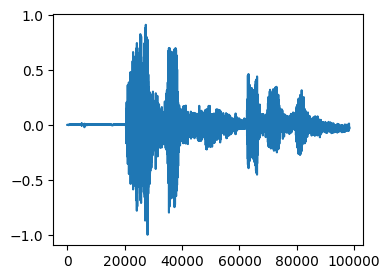

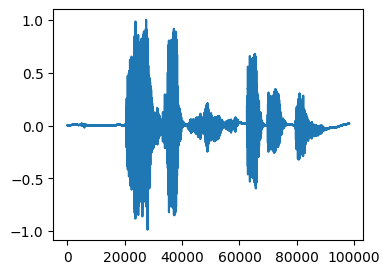

runs-exp-15-01-2024_many-to-many_stft+rev+emb:


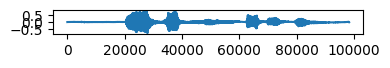

runs-exp-15-01-2024_one-to-many_stft+rev+emb:


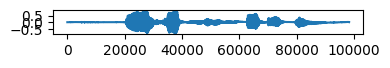

runs-exp-15-01-2024_one-to-many_stft+emb:


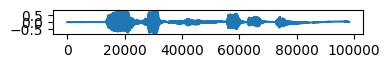

runs-exp-15-01-2024_many-to-many_stft+rev:


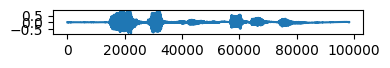

runs-exp-15-01-2024_many-to-many_stft:


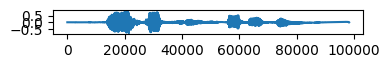

runs-exp-15-01-2024_one-to-many_stft+rev:


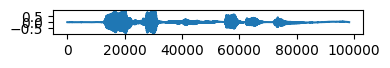

runs-exp-15-01-2024_one-to-many_stft:


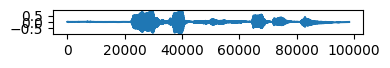

runs-exp-15-01-2024_many-to-many_stft+emb:


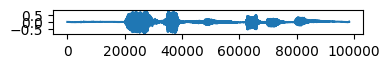

In [50]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################


plt.figure()
audio=sContents[0].squeeze(0).cpu()
plt.plot(audio)
plt.show()
display(Audio(audio,rate=48e3))

plt.figure()
audio=sTargets[0].squeeze(0).cpu()
plt.plot(audio)
plt.show()
display(Audio(audio,rate=48e3))

plt.figure()
for i,audio in enumerate(sPredictions):
    print(ModelTags[i]+":")
    plt.subplot(len(sPredictions),1,i+1)
    audio=sPredictions[i].squeeze(0).cpu()
    audio=audio.squeeze(0)
    wavfile.write("sounds/dp_"+str(dp)+"_"+ ModelTags[i]+".wav", int(48e3), audio.numpy())
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))

